      
      Seung-Nam Park    
      Division of Physical Metrology, Korea Research Institute of Korea 

# Introduction
Establishing calibration interval of measuring and test equipment (MTE) is the start point of a system analysis to maintain the system within a certain level of reliability. In general, the uncertainty of MTE grows after a calibration as time elapses, which finally results out of tolerance. A calibration history analysis of a group of MTEs enables us to probabilistically set a calibration interval. NCSL International published Recommended Practice-1 (RP-1), where A1~A3 and S1~S3 methods were proposed for establishment and adjustment of the interval. However, it is not easy to apply S1~S3 methods in practice without understanding a level of calculus, statistics and algorithm. Furthermore, RP-1 does not mention limitations of the methods caused of a sample size in analysis.  
Python recently becomes the most popular program language in scientific community, specially such as data science because of a wide range of powerful open-source packages including Scipy and Numpy. In this study, the S methods has been implemented in python based on the packages for readers to bridges over the fundamental knowledge on calculus and statistics. This author hopes readers to accept the interval analysis as a sub-branch of data science. This Jupyter notebook would be a pencil for a beginner to start to learn python through the interval analysis. Finally I would like to remind readers that  some parts of codes must be awkward because I am still a beginner in python as well. 

## Packages used

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.optimize import minimize
from scipy.stats import bernoulli, binom, norm, weibull_min
from numpy.random import exponential, randint, weibull
plt.style.use('ggplot')
np.random.seed(7)

# Magic command for pretty display
%precision 4
%matplotlib inline

## Random number generators (RNG)

RNG  is a crucial tool to simulate stochastic processes like occurrence of the out-of-tolerance (OOT)  of MTEs. Numpy provides RNGs for a part of reliability models. 

- The following functions with a name of **rnd_exp** and  **rnd_weibu** generate the elapsed time when an OOT happens following the exponential and weibull probability distribution RNG in Numpy.

In [2]:
def rnd_exp(th, samples=1):
    return exponential(1./th[0],samples)

def rnd_weibu(th, samples=1):
    return 1./th[0]* weibull(th[1], samples)

def mod_exp(th, t):
    return np.exp(-th[0]*t)

def mod_weibu(th, t):
    return np.exp(-(th[0]*t)**th[1])

-  The following code could be used as a RNG which is more generally applicable to the processes of which probability density function is explicitly available.  

In [3]:
 def rand_pdf(pdf, interval, pdfmax = 1, integers = False, 
              max_iterations = 10000):
    """
    Draws a random number from given probability density function.
    Parameters
    ----------
    pdf: the function pointer to a probability density function 
    of form P = pdf(x)
    interval: the resulting random number is restricted to this interval
    pdfmax  : the maximum of the probability density function
    integers: boolean, indicating if the result is desired as integer
    max_iterations: maximum number of 'tries' to find a combination of 
            random numbers (rand_x, rand_y) located below the function 
            value calc_y = pdf(rand_x).
    returns a single random number according the pdf distribution"""

    for i in range(max_iterations):
        if integers == True:
            rand_x = np.random.randint(interval[0], interval[1])
        else:
            rand_x = (interval[1] - interval[0]) * np.random.random(1) 
            + interval[0] #(b - a) * random_sample() + a

        rand_y = pdfmax * np.random.random(1) 
        calc_y = pdf(rand_x)

        if(rand_y <= calc_y ): 
            return rand_x
    
    raise Exception("Could not find a matching random number during " 
                        + max_iterations + " iterations.")

## Plot histograms of OOTs, cumulative distribution and reliability

In [4]:
def plot_sim_histo(samples,bins, cumcount, binsize, ti,gi):
    titles=['Elapsed time', 'Raw histogram', 
            'Cumulative histogram', 'Reliability histogram']
    fig, ax = plt.subplots(1,3, figsize=(15, 4))
    for i in range(3):
        ax[i].set_xlabel (titles[0])
        ax[i].set_xlim([ti.min(), ti.max()])
        ax[i].set_title(titles[i+1])    
    ax[0].hist(samples, bins=bins)
    ax[1].bar(ti, cumcount, width=binsize)
    ax[2].bar(ti, gi, width=binsize)
    plt.show

## Generate a set of artificial calibrations history
Assuming *f(x)* is a probability distribution governing OOTs, its probability distribution function (PDF) is normalized as 
$$\int_0^\infty f(x) dx =1 .$$

The cumulative distribution function(CDF) F(x) is obtained by the definite integral of the PDF from zero to the variable *t*.
$$F(t)=\int_0^t f(x) dx $$

The reliability function is expressed using cdf as 
$$ R(t)=1-F(t)=\int_t^\infty f(x)dx=1-\int_0^t f(x)dx $$

Differentiating the above equation yields the direct relation between the reliability function and the PDF.
$$ f(t)=  -\frac{\mathrm d R(t)}{\mathrm dt} $$
The relations are illustrated  as shown in the followings:

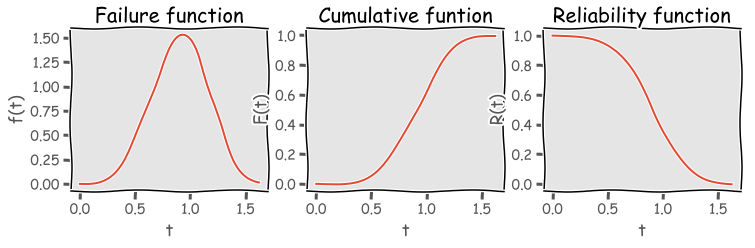

In [5]:
tit=['Failure function', 'Cumulative funtion',
     'Reliability function' ]
ylbl=[ 'f(t)', 'F(t)', 'R(t)']; c=4
x = np.linspace(0., weibull_min.ppf(0.999, c), 100)
with plt.xkcd():   # funny plot using xkcd()
    fig, ax= plt.subplots(1,3, figsize=(12, 3))
    for i in range(3):
        ax[i].set_xlabel('t')
        ax[i].set_ylabel (ylbl[i])
        ax[i].set_title(tit[i])
    ax[0].plot(x, weibull_min.pdf(x, c)) 
    ax[1].plot(x, weibull_min.cdf(x, c)) 
    ax[2].plot(x, 1-weibull_min.cdf(x, c)) 
plt.show()

A reliability distribution is obtained by a series of calibration experiments in a form of histogram which expresses frequencies of ITs versus time. Generating a set of artificial calibration history requires a reliability histogram which is obtained from the failure histogram via its cumulative  histogram.  The reliability histogram is considered as an raw data to predict the reliability model parameter.  
The parameter is expressed by a variable, lamda  in a form of  list in python to generalize the model with single parameter to models with multiple parameters. Weibull model has two parameters. 

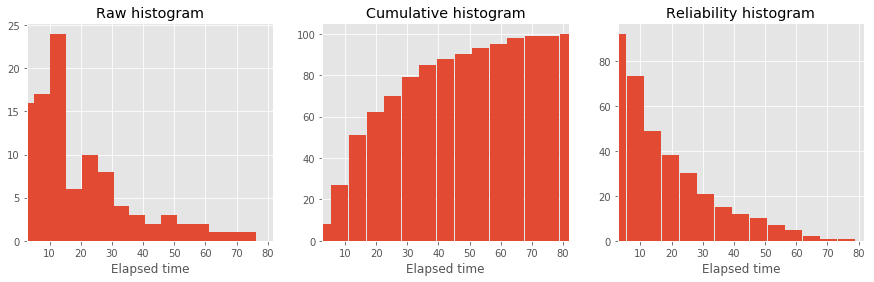

In [6]:
lamda=[0.05]; calno=100; bins=15 

samples=rnd_exp(lamda, calno)
res = st.cumfreq(samples, numbins=bins)
ti = np.linspace(0.5*res.binsize, res.binsize*res.cumcount.size,                                      
                 res.cumcount.size)
gi=calno - res.cumcount 
plot_sim_histo(samples, bins, res.cumcount, res.binsize, ti,gi) 

# S1 method
## Renewal policies
- There are three renewal policies in calibration: renew-always(**RA**), renew-needed(**RN**) and renew-if-failed(**RF**).  
- A special case of **RN** is **RF**, which lets us adjust  the MTEs exceeding a predeterminded adjustment limit.
- **S1_ra_lamda** calculates the parameter, lamda with a total calibration number(*calno*) and an interval(*itv*).

## RA policy
### skeleton code

The following code is to calculate the parameter of the exponential model, lambda in case of RA according to Equation (C-1) on the page 114 in RP-1. 

$$ \lambda=  \frac{X}{I-\frac{1}{2} \sum_{i=0}^N  X_i I_i}, $$

where *X* is the total number of observed OOTs, $X_i$ and *I* is the sum of the observed resubmission times  $I_i$. $X_i$ is 1 if the *i*th calibration record is OOT or 0 otherwise. In this calculation, a regular recalibration period was assumed for simplicity.

In [7]:
def S1_ra_lamda (thetas=[0.05], calno=1000000, itv=8):
    oot_t=np.array(rnd_exp(thetas, calno))
    X=np.array([oot_t<= itv])           
    return X.sum()/(itv*calno - 0.5*(X*itv).sum())

### Code test
- A big number of samples (*N =1000 000*) results in an agreement with the assumed value. The run time of the test is obtained using a build-in magic command, **%time**. ** %magic ** enables us to see the built-in manual of the magic commands.

In [8]:
N=1000000
%time res=S1_ra_lamda(thetas= [0.05], calno=N, itv=1)
print ('Determined lambda = %7.4f' % (res))

Wall time: 31.5 ms
Determined lambda =  0.0497


### Repeatability and convergence in determining the parameter

Calculate repeatability in determing the parameter as calibration number (*calno_var*) increase for various intervals(*itv_var*). The repeatability is in case of 10 repeat numbers (*rtp_no*). The vertical lines present the standard deviation on the mean of the repeat number.  The increase of the interval improves the convergence onto the assumed value of the parameter until a certain level of the interval. While the longer interval seems to show much better repeatability, the converged value deviates from the assumed value. It is because of high zero probability finding OOT for the longer calibration interval, which gives smaller parameter than the assumed value.        

In [9]:
def renew_always(lamda):
    itv_var= [1,2,4,8,16,32,64,128]
    calno_var=[20, 40, 80, 160, 320, 640]
    rpt_no=10

    plt_cnt=240
    plt.figure(figsize=(18,8))
    for itv in itv_var:
        plt_cnt=plt_cnt+1
        plt.subplot(plt_cnt, xscale="log")
        plt.xlabel ('Repeat number')
#        plt.ylabel ('lambda')
        plt.ylim(-0.02, 0.1)
        plt.xlim(10, 1000)
        plt.text(100, 0.09, 'interval= %2i' %itv)
        for calno in calno_var:
            th_rpt=[]
            for j in range(rpt_no):
                th_rpt.append(S1_ra_lamda(lamda, 
                                          calno, itv))
            
            plt.scatter([calno]*rpt_no, th_rpt)
            plt.errorbar(calno, np.array(th_rpt).mean(),
                         yerr=np.array(th_rpt).std(), 
                         ecolor='k', elinewidth=3)
    plt.show()
    return

#### In case of lamda = 0.05

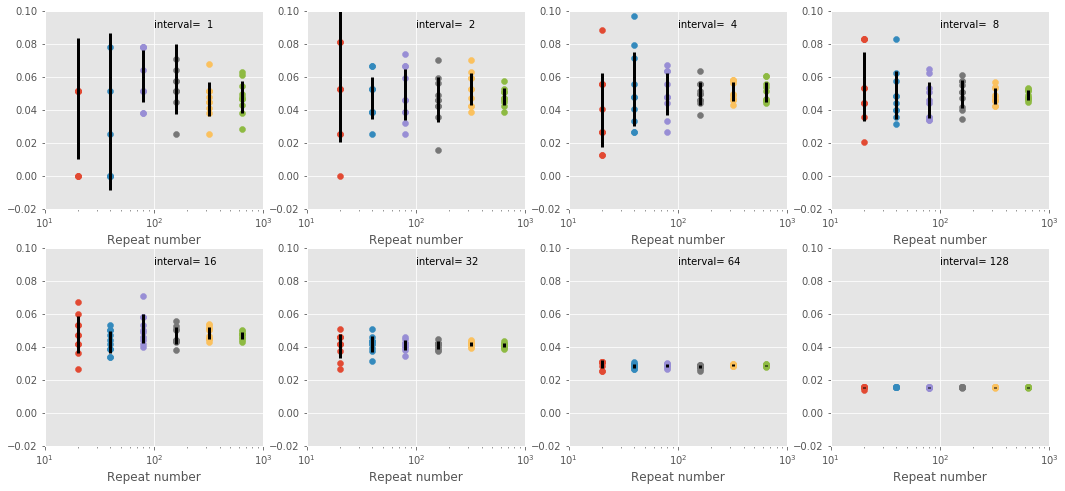

In [10]:
renew_always(lamda=[0.05])

#### In case of lamda = 0.02

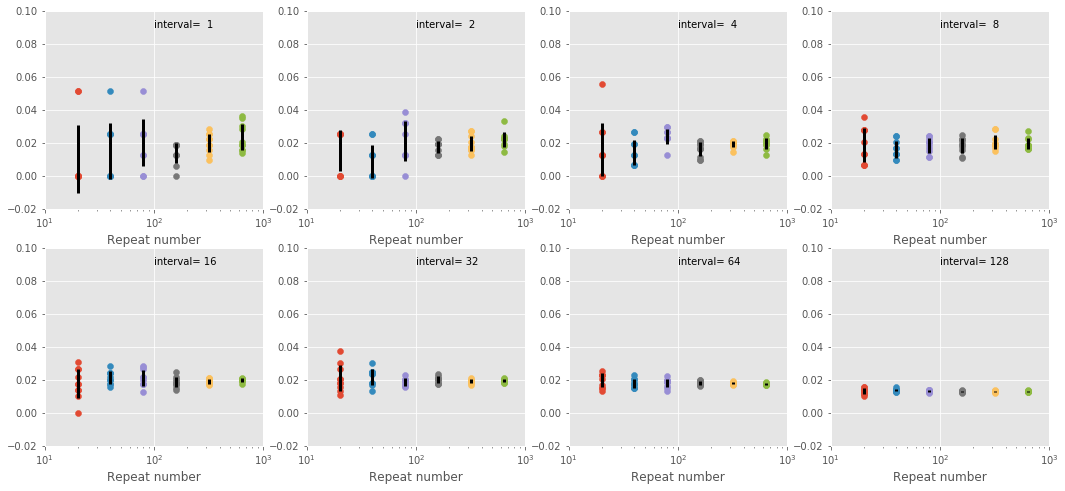

In [11]:
renew_always(lamda=[0.02])

## Renew-as needed

-  **gen_series_data** generates a time series calibration history for each MTE and returns  binary pairs of t and y, where the value of y represents in-tolerance  (=0) or out-of -tolerance (=1) of  a calibration window at  t.

In [12]:
def gen_series_data(thetas, rnd_model, mte_n=1, cal_no_l=50, 
                    cal_no_h=50, itv_l=1, itv_h=1, adj_no_it=0, debug=False):
    '''
    Generating calibration data with random number generator model
    (rnd_model) and variables
    Parameters: 
    mte_n: a number of MTEs
    cal_no_l: lowerlimit number of calibration of a MTE which may vary 
    with (cal_no_margin)
    cal_no_h: upperlimit number of calibration of a MTE which may vary 
    with (cal_no_margin)
    itv_l: lower limit of interval periods which is randomly determined
    itv_h: upper limit of intercal periods which is randomly determined
    adj_no_it: adjustment number even after in-tolerance
    
    Returns:
    t: time series data
    y: cal history serise where 0 means in-tol, 1 out-of-tol and adj, -1 
    in-tol and adj 
    '''       
    t, y=[],[]
    for j in range(mte_n):
        ct=[0]
        tzero =0
        n= randint(cal_no_l, cal_no_h+1)   #no of cal for a MTE
        itv= randint(itv_l, itv_h+1, n)
        rv = rnd_model(thetas)
        if debug: print (round(rv,1),) 
    
        for i in range(1,n+1): ct.append(itv[i-1]+ ct[i-1])
    
        oot=[0]*(n+1)
        for i in randint(1,n-1, adj_no_it): oot[i]=-1
        
        for i in range(n):
            if oot[i]==2: tzero= ct[i]        
            if (rv>= ct[i]-tzero) and (rv< ct[i+1]-tzero):
                if oot[i+1]==0: oot[i+1]=1
                tzero=ct[i+1]
                rv = rnd_model(thetas)
                if debug: print (round(rv,1),) 

        t.append(ct)
        y.append(oot)
    return t, y

In [13]:
def display_t_series(t, y, th, det_th):
    plt.figure(figsize=(18,8))
    plt.title ('S1 method')
    plt.xlabel('Elapsed time')
    plt.ylabel('MTE ID')
    plt.ylim(-0.5, 10.5)
    plt.text(t[0][-1]*0.4, 9.5, 'simulation')
    plt.text(t[0][-1]*0.5, 9.5, 'determined')
    
    for i in range(11): plt.hlines(i,0,t[0][-1])
    for i in range(mte): 
        for j in range(len(y[i])):  y[i][j]=y[i][j]*0.2+ i
    plt.scatter (t, y)
    plt.text(t[0][-1]*0.5, 8.5, 
             r'$\theta$1= '+  '%7.4f' %(det_th[0]))
    plt.text(t[0][-1]*0.4, 8.5, 
             r'$\theta$1= '+  '%7.4f' %(th[0]))
    plt.show()
    return

### Skeleton code for calculation of  $\lambda$ in case of RN

The following function is to calculate lambda according to Equation (C-4) on the page 114 in RP-1. The argument *y *is a time series data with a value of 0 or 1, where each y corresponds to its timing data of *t.  y* is represented by 1 or zero, where 0 means in-tolerance and 1 out-of-tolerance. 
$$ \lambda=  \frac{X}{T-\frac{1}{2} \sum_{i=0}^N  X_i I_i}, $$

where *T* is the sum of observed stop times, *N* the observed number of stop time, and $I_i$  the interval at which the adjustment took place. $X_i$ is 1 if the *i*-th calibration record is OOT or 0 otherwise. In this calculation, a regular recalibration period was assumed for simplicity.

In [14]:
def S1_rn_lamda(t,y):
    X= np.sum(y); I= np.sum(np.diff(t))
    XI=0
    for j in range(len(t)):
        for i in range(len(t[0])):
            if y[j][i]== 1: XI=XI+(t[j][i]-t[j][i-1])
    return [X/(I-0.5*XI)]

### Determination of $\lambda$

- In this calculation, **RF policy** is considered as an example of **RN**. The data points deviating from the horizontal line mean  OOTs in the following plot which includes the first 11 MTE's histories of all MTEs under analysis. 

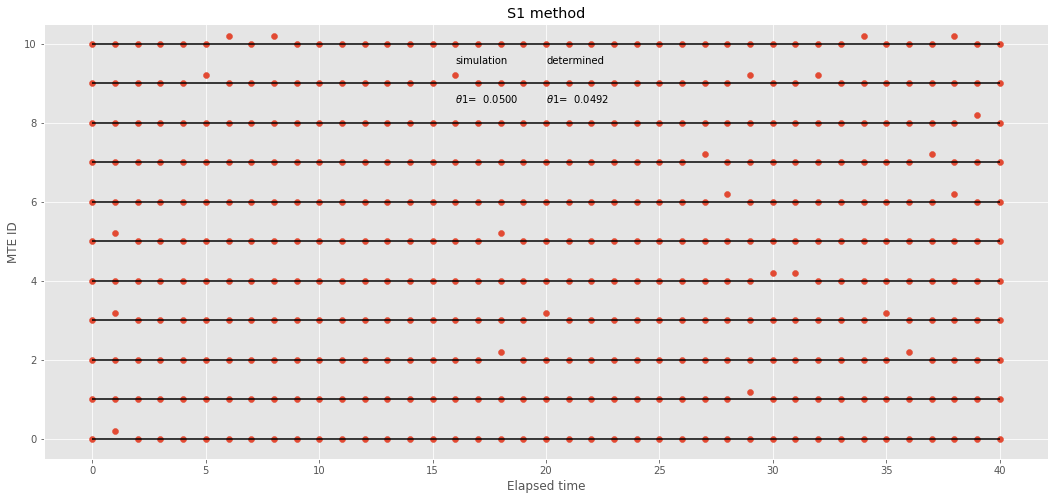

In [15]:
lamda=[0.05]
mte=50; calno=40; itv=1; adjno=0; debug=False
t,y=gen_series_data(lamda, rnd_exp, mte_n=mte, cal_no_l=calno, 
                    cal_no_h=calno,itv_l=itv, itv_h=itv)
display_t_series(t, y, lamda, S1_rn_lamda(t,y))

In [16]:
def renew_needed(lamda):
    itv_var= [2, 4, 8, 16]; mte=10
    calno_var=[10, 20, 40, 80, 160]
    rpt_no=10

    plt_cnt=220
    plt.figure(figsize=(12,8))
    for itv in itv_var:
        plt_cnt=plt_cnt+1
        plt.subplot(plt_cnt, xscale="log")
        plt.xlabel ('Repeat number')
        plt.ylabel ('lambda')
        plt.ylim(-0.02, 0.1)
        plt.xlim(5, 500)
        plt.text(100, 0.09, 'interval= %2i' %itv)
        for calno in calno_var:
            th_rpt=[]
            for j in range(rpt_no):
                t,y=gen_series_data(lamda, rnd_exp, mte_n=mte, 
                                    cal_no_l=calno, cal_no_h=calno, 
                                    itv_l=itv, itv_h=itv)
                th= S1_rn_lamda(t,y)
                th_rpt.append(th)
            plt.scatter([calno]*rpt_no, th_rpt)
            plt.errorbar(calno, np.array(th_rpt).mean(),
                         yerr=np.array(th_rpt).std(), 
                         ecolor='k', elinewidth=3)
    plt.show()
    return

### Repeatability and convergence in determining $\lambda$  value in case of RF

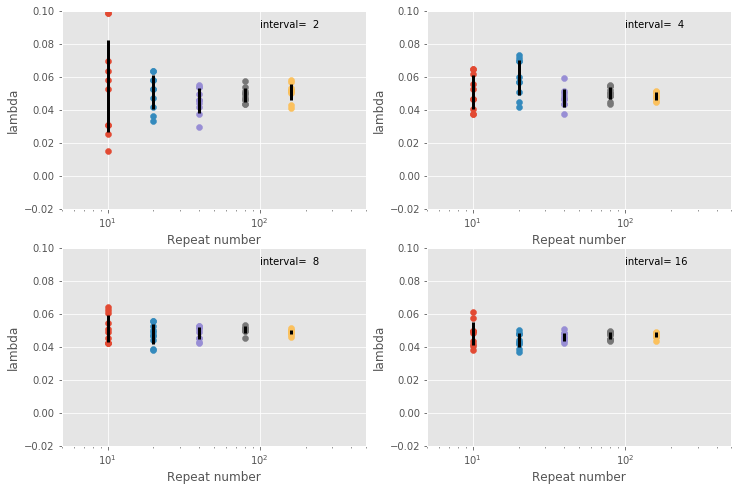

In [17]:
renew_needed(lamda=[0.05])

# S2 method

This method is to determine the parameters ($\theta$) which maximize the likelihood function as
$$  L= \sum_{i=1}^k \frac{n_i !}{g_i ! (n_i - g_i)!}  \hat{R} (t_i , \hat{\theta} )^g_i [1-\hat{R} (t_i , \hat {\theta} )]^{n_i -g_i}$$

 according to the probability law of the stochastic process,  where $\hat{R}(t, \hat{\theta})$, the reliability model follows a binomial distribution.
 The most difficult problem for maximizing it is solved using minimize method of the negative log of the likelihood function in Scipy.

- The following is the key code to do that.

In [18]:
def neg_loglik(thetas, model, tx, gx, nx):
    return -np.sum([binom(n, model(thetas, t)).logpmf(g)
                                     for (t, g, n) in zip(tx, gx, nx)])

## Code test with typical OOT time series example
- Using the raw data appearing in Table D-1 on the page 119 of RP-1.

![TableD-1 in RP-1](Tbl-D-1.png)


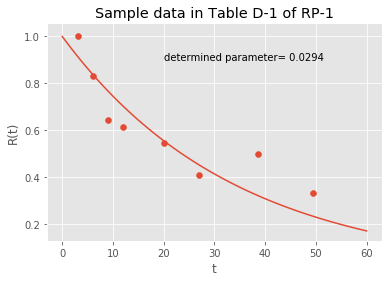

In [19]:
ti=[3, 6, 9, 12, 20, 27, 38.5, 49.5]
ni=[4, 6, 14, 13, 22, 49, 18, 6]
gi=[4, 5, 9,  8, 12, 20, 9,2]
#print ('{} {}{}{}'.format('       t    ', 'ni(t)       ', 'g(t)       ' , 'R(t)' ))
#for i in range( 6):
#    print ('{:7.2f} {:7.2f}{:7.2f}{:7.2f}'.format(ti[i], ni[i] , gi[i], gi[i]/ni[i]))

plt.scatter(ti, np.divide(gi,ni))
thetas=minimize(neg_loglik, [0.05], args=(mod_exp, ti,gi,ni), 
                bounds=[(0., 1.)], method='SLSQP', 
                options={'maxiter': 100})
if thetas.success:
    t = np.linspace(0, 60, 100)
    plt.plot (t, mod_exp(thetas.x,t))
    plt.xlabel('t'); plt.ylabel('R(t)')
    plt.title ('Sample data in Table D-1 of RP-1')
    plt.text(20, 0.9, 'determined parameter= %6.4f' %(thetas.x[0]))
plt.show()

## Generate artificial time series using RNG
- following the exponential and Weibull models

#def gen_S2_data(thetas, rnd_model, mte_no, w_no, plt_on=False):
    samples=rnd_model(thetas, mte_no)
    res = st.cumfreq(samples, numbins=w_no)
    ti = np.linspace(0.5*res.binsize, res.binsize*res.cumcount.size, 
                                     res.cumcount.size)
    gi=mte_no-res.cumcount; ni=[mte_no]*w_no 
    if plt_on: 
        plot_sim_histo(samples,w_no, res.cumcount, res.binsize, ti,gi)
    return ti, ni, gi

In [20]:
def gen_S2_data(thetas, rnd_model, mte_no, win, plt_on=False):
    zi=[]
    for i in range(mte_no):
        oott= rnd_model(thetas, 1)
        z=[]
        for j in range(100000):
            if oott<j*win and oott<=win*(j+1):
                z.append(0)
                break
            else:
                z.append(1)
        zi.append(z)
    print (zi)
    
    tmp=[]    
    for i in range(mte_no):
        tmp.append(zi[i].index(0))
    print (tmp)
    
    n=len(tmp); ti=[]; gi=[]; ni=[]
    for i in range(np.max(tmp)+1):
        nz=tmp.count(i)
        if nz!=0:
            ti.append((i-0.5)*win)
            gi.append(n-nz)
            ni.append(n)
            print ((i-0.5)*win, n-nz, n, (n-nz)/n)
            n=n-nz
    return ti, ni, gi

In [21]:
def gen_S2_data____(thetas, rnd_model, mte_no, win, plt_on=False):
    res = st.cumfreq(samples, numbins=w_no)
    ti = np.linspace(0.5*res.binsize, res.binsize*res.cumcount.size, 
                                     res.cumcount.size)
    gi=mte_no-res.cumcount; ni=[mte_no]*w_no 
    if plt_on: 
        plot_sim_histo(samples,w_no, res.cumcount, res.binsize, ti,gi)
    return ti, ni, gi

In [22]:
def plot_param_converse (r, mte_var, repeat_no, plt_title):       
    npr=np.array(r)
    plt.figure(figsize=(12, 5))
    for i in range(len(r[0][0])):
        plt.subplot(121+i, xscale="log") 
        plt.title (plt_title + ' (theta %1i)' %(i+1))
        plt.xlabel('Number of MTE')
        plt.scatter([mte_var]*repeat_no, npr[:,:,i])
        avg=[]; stdv=[]
        for j in range(len(r[0])):
            avg.append (npr[0:len(r),j,i].mean())
            stdv.append(npr[0:len(r),j,i].std())
        plt.errorbar(mte_var, avg, yerr=stdv, ecolor='k', elinewidth=3)    
    plt.show()
#    plt.savefig(plt_title + '_par_conv.png', dpi=300)
    return

## Practical raw data and prediction of its parameters

In [23]:
D=[[0, [0.05], [0.01], [(0.,10.)], 
    mod_exp,'exponential', rnd_exp],
   [1, [0.03, 3.5], [(0.01,1.0)],[(0.,1.),(0., 10.)], 
    mod_weibu, 'Weibul', rnd_weibu]]
np.random.seed(101)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

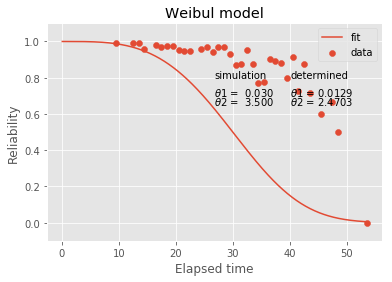

In [24]:
swboard=(1,); debug=False; mte=100; w_no=1; plot_on=True

for sw in swboard:
    th= D[sw][1]; inits=D[sw][2];  bounds=D[sw][3]; plt_title=D[sw][5]
    model= D[sw][4]; rnd_model=D[sw][6]
    if debug: print (t, y) ;print ('number of adjustment =', adj_no(t,y))
    ti, ni, gi= gen_S2_data(th, rnd_model, mte_no=mte, 
                            win=w_no, plt_on=plot_on)    

    thetas=minimize(neg_loglik, inits, args=(model, ti,gi,ni), 
                    bounds=bounds, method='SLSQP', 
                    options={'maxiter': 100})
    if thetas.success:
        fig = plt.figure()
        plt.scatter (ti,[(x*1.0)/y for x, y in zip(gi, ni)], label="data")
        plt.title (plt_title + ' model')
        plt.ylim(-0.1,1.1)
        plt.xlabel('Elapsed time')
        plt.ylabel('Reliability')        
        t=np.arange(0.1, ti[-1], 0.1)
        plt.plot(t, model(th, t), label='fit')

        plt.text(ti[-1]/2, 0.8, 'simulation')
        plt.text(ti[-1]/2+ti[-1]/4, 0.8, 'determined')    
        for i in range(len(thetas.x)): 
            plt.text(ti[-1]/2+ti[-1]/4, 0.7 - 0.05*i, 
                     r'$\theta$' + '%1i = %6.4f' %(i+1,thetas.x[i]))
            plt.text(ti[-1]/2, 0.7 - 0.05*i, 
                     r'$\theta$' + '%1i = %6.3f' %(i+1,th[i]))
        plt.legend()
        plt.show()
    else:
        print ('minimization failed because '+ thetas.message)
        quit()    

## Repeatability and convergence in predicting the parameters

In [25]:
np.random.seed(103)
swboard=(0,1); debug=False; calno=30; w_no=15; plot_on=False
repeat_no=10;  mte_var=[8, 16, 32, 64, 128, 256]

for sw in swboard:
    th= D[sw][1]; inits=D[sw][2]; bounds=D[sw][3]
    plt_title=D[sw][5]; model= D[sw][4]; rnd_model=D[sw][6]
    plt_title=D[sw][5]
    
    r=[]
    for k in range(repeat_no):
        r2=[]
        for mte in mte_var:
            ti, ni, gi= gen_S2_data(th, rnd_model, mte_no=mte, 
                                    w_no=w_no, plt_on=plot_on)    

            thetas=minimize(neg_loglik, inits, args=(model, ti,gi,ni), 
                            bounds=bounds, method='SLSQP', 
                            options={'maxiter': 100})

            if thetas.success:
                r3=[]
                for j in range(len(thetas.x)):
                    r3.append (thetas.x[j])
            else:
                print ('minimization failed because '+ thetas.message)
        
            r2.append(r3)
        r.append(r2)
    plot_param_converse (r, mte_var, repeat_no, plt_title)

TypeError: gen_S2_data() got an unexpected keyword argument 'w_no'

## using gen_series_data

In [26]:
D=[[0, [0.05], [0.05], [(0.,1.)], 
    mod_exp,'exponential', rnd_exp],
   [1, [0.03, 3.50], [(0.05, 1.)],[(0,1.),(0., 20.)], 
    mod_weibu, 'Weibul', rnd_weibu]]

In [27]:
swboard=(0,); debug=False; mte=1; calno=1000; adjno=0

for sw in swboard:
    th= D[sw][1]; inits=D[sw][2];  bounds=D[sw][3]
    plt_title=D[sw][5]; model= D[sw][4]
    rnd_model=D[sw][6]
    if debug: print (t, y ); print ('number of adjustment =', 
                                    adj_no(t,y))

    t,y=gen_series_data(th, rnd_model, mte_n=mte, 
                        cal_no_l=calno, cal_no_h=calno, itv_l=1, 
                        itv_h=1, adj_no_it=adjno, debug=False)
print (np.sum(y))

62


# S3 method- Renewal Time Method

that is a improvement of S2 to be able to accommodate various renewal policies reflecting the calibrations in practice. It requires the different method as S2 in forming the the time series data. The logarithm of the total likelihood function is described in the equation (E-8) on the page 144 of RP-1.

$$ln L=\sum_{i=1}^N \sum_{j=1}^{n_i}  [x_{ij} ln \rho_{ij }+ (1-x_{ij}) ln(1- \rho_{ij} )+ln r_{ij}],$$

where 
$$r_j= r(\tau_j) =R(\tau_j - I_j), $$

$$ \rho_j =R(\tau_j) / r(\tau_j), $$

$$ x_j= 
  \begin{cases}
    1,       & \text{if the j-th renewal with a period of }  \tau_j  \text { is for an in-tolerance}\\
    0,  & \text{otherwise}
  \end{cases} $$

$\tau_j$ is the elapsed time after the previous adjustment, $\tau_{j-1}$  and  $\tau_1$  is the elapsed time from the start of the analysis to the first adjustment.

## Likelihood function for S3 method

- The negative logarith of the total likelihood function for S3 method can be calculated by the following code:

In [28]:
def neg_loglik_S3(thetas, model, t, y):
    log_lik=0.
    for i in range(len(t)): 
        t_st=t[i][0]
        for j in range(len(t[i])):
            if y[i][j]!=0:
                tau_ij=t[i][j]-t_st
                t_st=t[i][j]
                
                if y[i][j]== -1: #if adjusted in tolerance,
                    x_ij= 1 
                else: 
                    x_ij=0
                r_ij= model(thetas,tau_ij- (t[i][j]-t[i][j-1]))
                ro_ij= model(thetas, tau_ij)/r_ij
                tp= x_ij*np.log(ro_ij)+(1.-x_ij)*np.log(1.-ro_ij)+np.log(r_ij)
                log_lik= log_lik +tp
    return -log_lik

def adj_no(y):
     return np.count_nonzero(y)

In [29]:
D=[[0, [0.03], [0.05], [(0.,1.)], 
    mod_exp,'exponential', rnd_exp],
   [1, [0.03, 3.50], [(0.05, 1.)],[(0,1.),(0., 20.)], 
    mod_weibu, 'Weibul', rnd_weibu]]

## Generating time series data and predicting the parameters

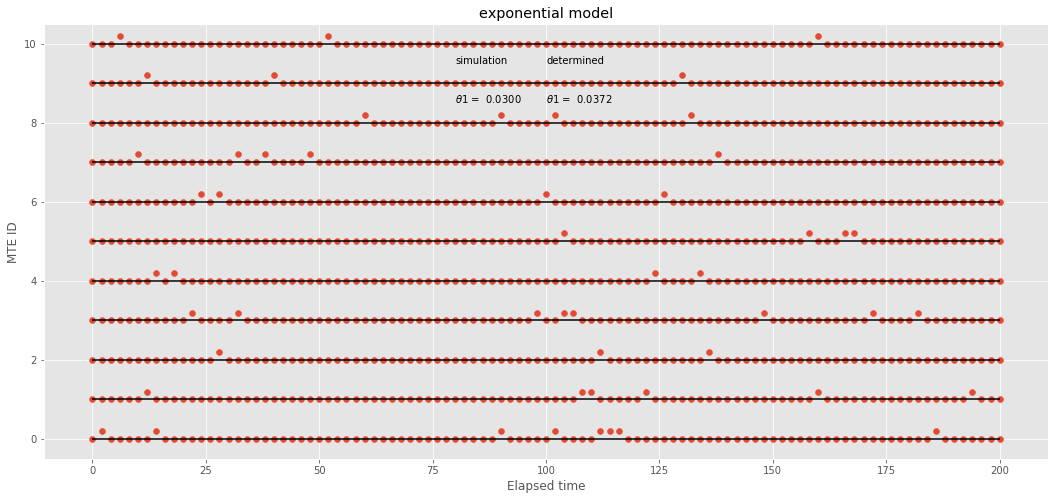

C:\Users\snp_macmini\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\snp_macmini\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\snp_macmini\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


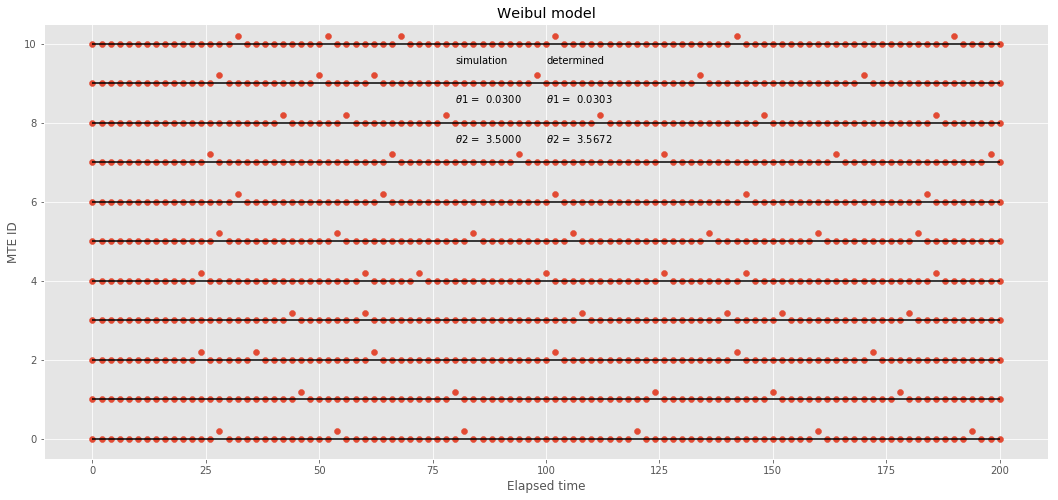

In [30]:
swboard=(0,1); debug=False; mte=50; calno=100; adjno=0

for sw in swboard:
    th= D[sw][1]; inits=D[sw][2];  bounds=D[sw][3]
    plt_title=D[sw][5]; model= D[sw][4]
    rnd_model=D[sw][6]
    if debug: print (t, y ); print ('number of adjustment =', 
                                    adj_no(t,y))

    t,y=gen_series_data(th, rnd_model, mte_n=mte, 
                        cal_no_l=calno, cal_no_h=calno, itv_l=2, 
                        itv_h=2, adj_no_it=adjno, debug=False)
    thetas= minimize(neg_loglik_S3, inits, args=(model,t,y), 
                         bounds=bounds, method='SLSQP', 
                     options={'maxiter': 50})
    if debug: print (thetas)
    if thetas.success: 
        plt.figure(figsize=(18,8))
        plt.title (plt_title + ' model')
        plt.xlabel('Elapsed time')
        plt.ylabel('MTE ID')
        plt.ylim(-0.5, 10.5)
        for i in range(11): plt.hlines(i,0,t[0][-1])
        for i in range(mte): 
                for j in range(len(y[i])):  y[i][j]=y[i][j]*0.2+ i
        plt.scatter (t, y)
        plt.text(t[0][-1]*0.4, 9.5, 'simulation')
        plt.text(t[0][-1]*0.5, 9.5, 'determined')
        for i in range(len(thetas.x)):
            plt.text(t[0][-1]*0.5, 8.5-i, 
                     r'$\theta$' + '%1i = %7.4f' %(i+1,thetas.x[i]))
            plt.text(t[0][-1]*0.4, 8.5-i, 
                     r'$\theta$' + '%1i = %7.4f' %(i+1,th[i]))
        plt.show()
    
    else:
        print ('minimization failed because '+ thetas.message);   

## Repeatability and convergence of the parameters

C:\Users\snp_macmini\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


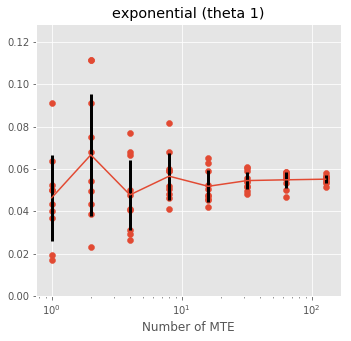

C:\Users\snp_macmini\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\snp_macmini\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


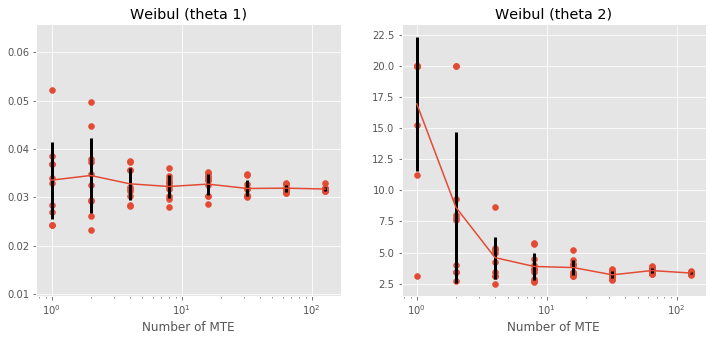

In [31]:
swboard=(0,1); debug=False;  mte=50; calno=30; adjno=0
repeat_no=10;  mte_var=[1, 2, 4, 8, 16, 32, 64, 128]

for sw in swboard:
    th= D[sw][1]; inits=D[sw][2]; bounds=D[sw][3]
    plt_title=D[sw][5]; model= D[sw][4]; rnd_model=D[sw][6]
    plt_title=D[sw][5]
    
    r=[]
    for k in range(repeat_no):
        r2=[]
        for mte in mte_var:
            t,y=gen_series_data(th, rnd_model, mte_n=mte, 
                                cal_no_l=calno, cal_no_h=calno,itv_l=2, 
                                itv_h=2, adj_no_it=adjno, debug=False)
            thetas= minimize(neg_loglik_S3, inits, args=(model,t,y), 
                             bounds=bounds, method='SLSQP', 
                             options={'maxiter': 50})
            if thetas.success:
                r3=[]
                for j in range(len(thetas.x)):r3.append (thetas.x[j])
            else:
                print ('minimization failed because '+ thetas.message)
            r2.append(r3)
        r.append(r2)
    plot_param_converse (r, mte_var, repeat_no, plt_title)    

# More reliability models

There are more reliability models proposed in RP-1 in addition to the exponential and Weibull models. The drift model equation written in the current version must be wrong because the reliability value at *t*=0 does not give unity. The drift model is excluded in this calculation. 
## Model equations

In [32]:
def mod_mixexp(th, t):
    return (1.+ th[0]*t)**(-th[1])

def mod_rndwalk(th, t):
    return 2.*norm.cdf(1./(th[0]+th[1]*t)**0.5)-1.0

def mod_rrndwalk(th, t):
    return 2.*norm.cdf(1./(th[0]+th[1]*(1.-np.exp(-th[2]*t)))**0.5)-1.0

def mod_mgamma(th, t):
    return np.exp(-th[0]*t)*(1.+th[0]*t+ 0.5*(th[0]*t)**2+1./6*(th[0]*t)**3)

def mod_mdrift(th, t):
    return np.exp(-th[0]*t-th[1]*t**2)

def mod_warrant(th,t):
    return 1./(1.+np.exp(th[0]*(t-th[1])))

def mod_drift(th, t):
    return norm.cdf(th[0]+th[2]*t)+norm.cdf(th[1]-th[2]*t)

def mod_lognorm(th, t):
    return 1.-norm.cdf(np.log(th[0]*t)/th[1])

## Code for data generations

In [33]:
def sim_dat (model,thetas, t_start, t_end, t_int):
    ti=np.arange(t_start, t_end, t_int)
    ni=np.random.randint(5, 11, len(ti))
    gi=np.round(model(thetas, ti)*ni)
    return ti, ni, gi

## Parameters for models
- Assumed parameters, initial guesses and bounds of the parameters is given using a list of python. 

In [34]:
dat=[[0, [0.05], [0.001],[(0.,1.)], 
      mod_exp,'exponential'],
     [1, [0.03, 3.50], [(0.001, 1.)],[(0.,1.),(0., 10.)], 
      mod_weibu, 'Weibul'],
     [2, [2.00, 0.10], [(0.1, 0.01)],[(0.,10.),(0., 1.)], 
      mod_mixexp, 'mixed exponential'],
     [3, [0.30, 0.05], [(0.1, 0.01)],[(0.,10.),(0., 1.)], 
      mod_rndwalk, 'random walk'],
     [4, [0.50, 1.00, 0.1], [(0.3, 2.0, 0.2)],[(0., 10.),(0.,10.),(0., 10.)], 
      mod_rrndwalk, 'restricted random walk'],
     [5, [0.16], [0.1], [(0.,10.)], 
      mod_mgamma,'modifed gamma'],
     [6, [0.0068, 0.0016], [(0.001, 0.001)],[(0.,1.),(0., 1.)], 
      mod_mdrift, 'mortality drift'],
     [7, [0.2, 30.], [(0.1, 1.)],[(0.,10.),(0., 100.)], 
      mod_warrant, 'warranty'],
     [8, [2.5, 0.5, 0.5], [(0.5, 0.1, 1.1)],[(0., 10.),(0.,10.),(0., 10.)], 
      mod_drift, 'drift'],
     [9, [0.05, 0.5], [(0.04, 0.8)],[(0.,10.),(0., 10.)], 
      mod_lognorm, 'lognormal'],]

## Determination of most likelihood parameters

In [ ]:
swboard= (0,1,2,3,4,5,6,7,9)
t_start, t_end, t_int = 4, 60, 4
plt.figure(figsize=(12,30)); plt_cont=520

for sw in swboard:    
    th, inits, bounds, model = dat[sw][1], dat[sw][2], dat[sw][3], dat[sw][4]
    plt_title= dat[sw][5]
    
    ti, ni, gi = sim_dat(model, th, t_start, t_end, t_int)
    thetas= minimize(neg_loglik, inits, args=(model, ti,gi,ni),
                     bounds=bounds, method='SLSQP', 
                     options={'maxiter': 50})
    if thetas.success:
        plt_cont=plt_cont+1
        plt.subplot(plt_cont)
        plt.scatter (ti,np.divide(gi,ni), label="data")
        plt.title (plt_title + ' model')
        plt.ylim(-0.1,1.1)
        plt.xlabel('Elapsed time')
        plt.ylabel('Reliability')        
        t=np.arange(0.1, ti[-1], 0.1)
        plt.plot(t, model(th, t), label='fit')
        
        plt.text(0, 0.2, 'simulation')
        plt.text(15, 0.2, 'determined')
        for i in range(len(thetas.x)): 
            plt.text(15, 0.15 - 0.05*i, 
                     r'$\theta$' + '%1i = %6.3f' %(i+1,thetas.x[i]))
            plt.text(0, 0.15 - 0.05*i, 
                     r'$\theta$' + '%1i = %6.3f' %(i+1,th[i]))
        plt.legend()
    else:
        print ('minimization failed because '+ thetas.message)
        quit()    
plt.show()
#plt.savefig('maxlikfits.png', dpi=300)

# Summary
 
<div style="text-align:center">**Modeling establishment of calibration interval for various reliability models using Scipy package**  </div>

Establishing calibration interval of measuring and test equipment (MTE) is the start point of a system analysis to maintain the system within a certain level of reliability. In general, the uncertainty of MTE grows after a calibration as time elapses, which finally results out of tolerance. A calibration history analysis of a group of MTEs enables us to probabilistically set a calibration interval. NCSL International published Recommended Practice-1 (RP-1), where A1~A3 and S1~S3 methods were proposed for establishment and adjustment of the interval. However, it is not easy to apply S1~S3 methods in practice without understanding a level of calculus, statistics and algorithm. Furthermore RP-1 does not mention limitations of the methods caused of a sample size in analysis. In this study, we carried out Monte Caro simulations to obtain virtual calibration histories using Scipy running on IPython for S1~S3 methods. In case of S2 and S3, the exponential and Weibull model were intensively investigated. The parameters of the reliability models were determined to maximize the likelihood functions using the minimize method of Scipy. We observed that the parameters approach the values presumed in the simulations as a number of recalibrations increases  
> **Keywords**: *calibration, calibration interval, reliability model, exponential model, Weibull model*
>
>*This summary was written for the abstract presented in an oral session of **KSPE 2019 Spring Conference** held in Jeju. by S-N Park, H S Shim, and J S Park .

# Reference
1. Recommended Practice-1: Establishment and adjustment of calibration intervals, NCSL International  , ISBN 978-1-58464-062-2 (2017)
1. https://towardsdatascience.com/jupyter-notebook-extensions-517fa69d2231: Configurable Jupyter notebook extension has helped this work and will be hepful for readers. 
1. https://ipython.readthedocs.io/en/stable/interactive/magics.html: Built-in magic commands
1. https://en.wikibooks.org/wiki/LaTeX/Mathematics: LaTex 
1. https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6: Interactive widgets in python

# Acknowledgment

This study was supported by 2019 KOLAS Program for improving traceability between NMI and the calibration laboratories and 2019 Internal Fund of Division of physical metrology at KRISS.


In [4]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')